Форма данных: (400, 4096)


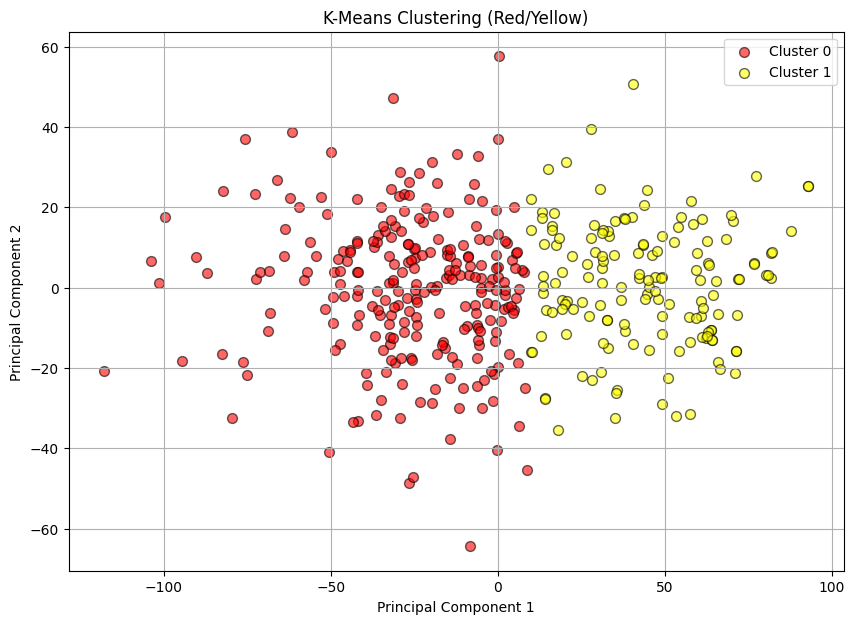

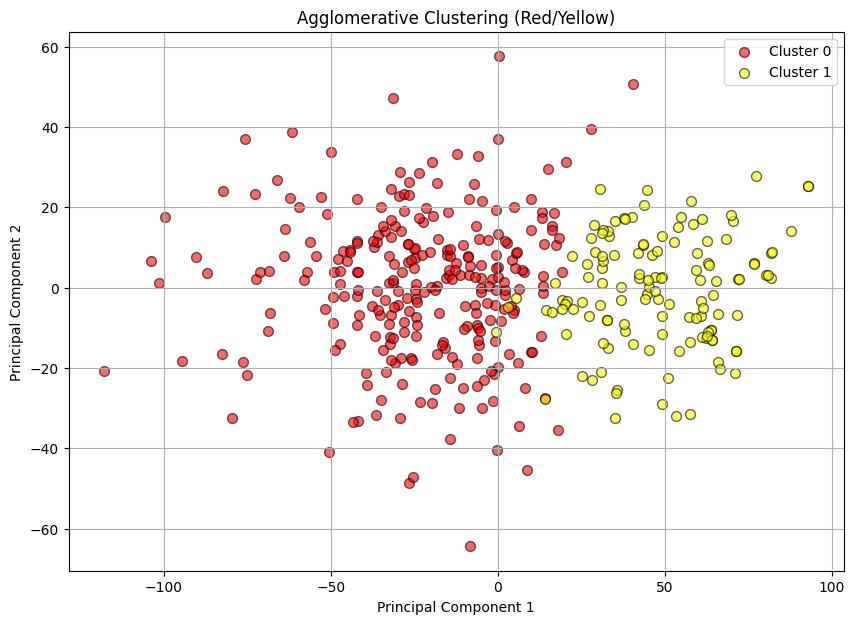

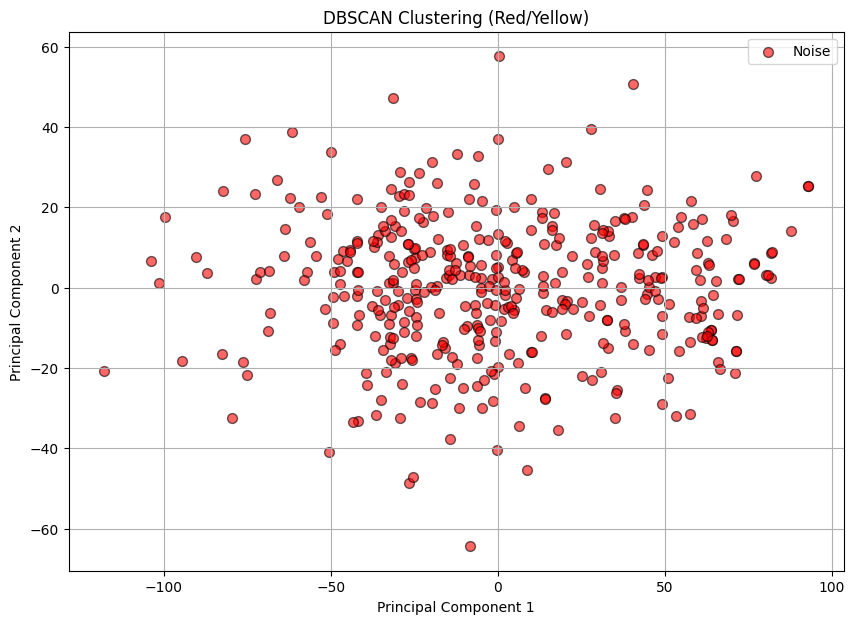


Оценка качества кластеризации:
K-Means Silhouette: 0.234
Agglomerative Silhouette: 0.230


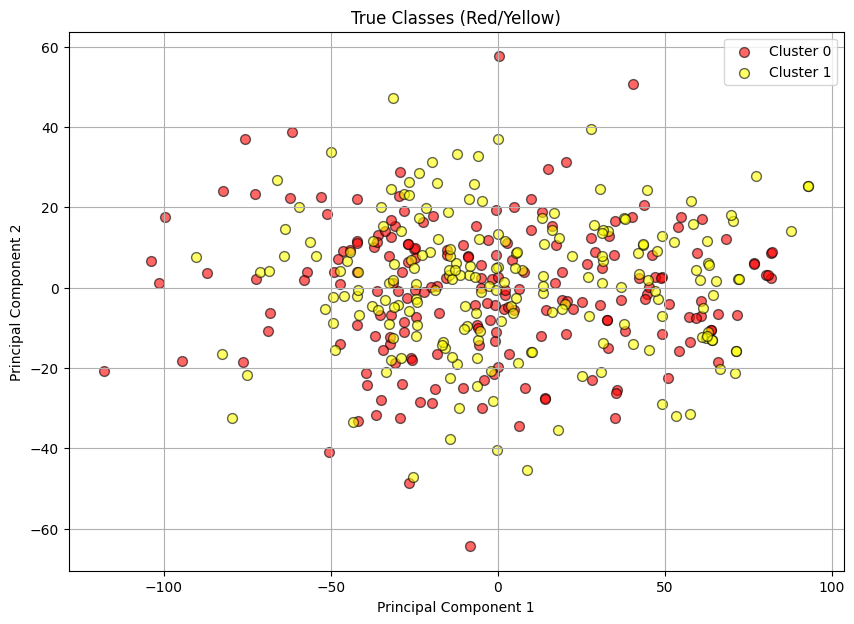

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from PIL import Image
import os

# === 1. Загрузка и подготовка данных ===
data_dir = "cats and dogs"
classes = sorted(os.listdir(data_dir))

X = []
y = []
image_paths = []

image_size = (64, 64)  # уменьшенный размер для быстрой обработки

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path)[:200]:  # ограничим количество для демонстрации
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert('L').resize(image_size)
            img_array = np.array(img).flatten() / 255.0  # нормализация [0, 1]
            X.append(img_array)
            y.append(class_idx)
            image_paths.append(img_path)
        except Exception as e:
            print(f"Ошибка загрузки {img_path}: {e}")

X = np.array(X)
y = np.array(y)
print(f"Форма данных: {X.shape}")

# === 2. Предобработка данных ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Уменьшение размерности для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Функция для визуализации кластеров с двумя цветами
def plot_clusters_red_yellow(data, labels, title):
    plt.figure(figsize=(10, 7))
    
    # Создаем цветовую карту: красный (0) и желтый (1)
    colors = ['red', 'yellow']
    
    # # Для шума  используем серый
    # if -1 in labels:
    #     colors = ['gray'] + colors
    
    for i, label in enumerate(sorted(set(labels))):
        color_idx = 1 if label == 1 else 0  # 0 -> red, 1 -> yellow
        plt.scatter(data[labels == label, 0], 
                   data[labels == label, 1], 
                   color=colors[color_idx], 
                   label=f'Cluster {label}' if label != -1 else 'Noise',
                   alpha=0.6,
                   edgecolor='black',  # добавляем черную обводку для лучшей видимости
                   s=50)  # размер точек
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# === 3. Кластеризация ===
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
plot_clusters_red_yellow(X_pca, kmeans_labels, 'K-Means Clustering (Red/Yellow)')

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(X_scaled)
plot_clusters_red_yellow(X_pca, agg_labels, 'Agglomerative Clustering (Red/Yellow)')

# DBSCAN
dbscan = DBSCAN(eps=3.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
plot_clusters_red_yellow(X_pca, dbscan_labels, 'DBSCAN Clustering (Red/Yellow)')

# === 4. Оценка качества ===
print("\nОценка качества кластеризации:")
print(f"K-Means Silhouette: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"Agglomerative Silhouette: {silhouette_score(X_scaled, agg_labels):.3f}")
if len(set(dbscan_labels)) > 1:  # DBSCAN может найти только 1 кластер
    print(f"DBSCAN Silhouette: {silhouette_score(X_scaled, dbscan_labels):.3f}")

# === 5. Визуализация истинных классов ===
plot_clusters_red_yellow(X_pca, y, 'True Classes (Red/Yellow)')